In [1]:
import h5py
from keras.utils import to_categorical
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model

import numpy as np
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
class Corpus:
    """
    m        = Number of Total Examples available in this corpus
    XD,YD    = Decoded Feature, Label. Single dimension list of Strings.
    XE,YE    = Encoded Feature, Label. Multi dimensional numpy array.
    XD.shape = (m,Tx,Vx)
    YD.shape = (m,Vx) i.e Tx = 1 for label. Multi input, one output vector.
    """
    def __init__(self, train_dfile,test_dfile):
        ds = h5py.File(train_dfile, "r")
        self.X_train = ds['train_set_x'].value
        self.y_train = ds['train_set_y'].value
        self.classes = ds['list_classes'].value
        self.num_classes = len(self.classes)
        self.num_samples = self.X_train.shape[0]
        ds = h5py.File(test_dfile, "r")
        self.X_test = ds['test_set_x'].value
        self.y_test = ds['test_set_y'].value
        self.transform()
        
    def transform(self):
        self.X_train = self.X_train/255
        self.X_test  = self.X_test/255

        self.y_train = to_categorical(self.y_train,num_classes=self.num_classes)
        self.y_test  = to_categorical(self.y_test, num_classes=self.num_classes)

    def __str__(self):
        s = ''
        s += 'X_train.shape = ' + str(self.X_train.shape) + '\n'
        s += 'y_train.shape = ' + str(self.y_train.shape) + '\n'
        s += 'X_test.shape  = ' + str(self.X_test.shape) + '\n'
        s += 'y_test.shape  = ' + str(self.y_test.shape) + '\n'
        s += 'Classes = '       + str(self.classes) + '\n'
        return s
    
    def show(self):
        idx = np.random.randint(0,self.num_samples)
        plt.imshow(self.X_train[idx])
        print('value = ',np.argmax(self.y_train[idx]))
        
        

        

/Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


X_train.shape = (1080, 64, 64, 3)
y_train.shape = (1080, 6)
X_test.shape  = (120, 64, 64, 3)
y_test.shape  = (120, 6)
Classes = [0 1 2 3 4 5]

value =  2


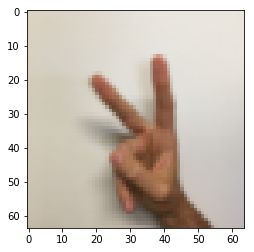

In [3]:
crp = Corpus('data/train_signs.h5','data/test_signs.h5')
print(crp)
crp.show()

## Model

Lets build the following model: `CONV2D((4,4),f=8) -> RELU -> MAXPOOL(8,8 stride = (8,8), pad=same) -> CONV2D((2,2),f=16) -> RELU -> MAXPOOL((4,4),stride=(4,4),pad='same') -> FLATTEN -> FULLYCONNECTED`.

In [4]:
def build_model():
    
    X_input = Input(shape=(64,64,3))
    
    X = Conv2D(kernel_size = (4, 4), filters = 16, padding = 'same', name = 'conv_k4x4_f16')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu',name='Relu1')(X)
    X = MaxPooling2D((8, 8), strides=(8, 8),padding='same',name='k8x8_s8x8')(X)
    
    X = Conv2D(kernel_size = (2, 2), filters = 32, padding = 'same', name = 'conv_k2x2_f32')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu',name='Relu2')(X)
    X = MaxPooling2D((4, 4), strides=(4, 4),padding='same',name='k4x4_s4x4')(X)
    
    X = Flatten()(X)
    X = Dense(crp.num_classes)(X)
    X = Activation('softmax',name='Softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    return model

In [5]:
model = build_model()

W1120 14:39:24.363583 4550874560 deprecation_wrapper.py:119] From /Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1120 14:39:24.377502 4550874560 deprecation_wrapper.py:119] From /Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1120 14:39:24.380849 4550874560 deprecation_wrapper.py:119] From /Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1120 14:39:24.424271 4550874560 deprecation_wrapper.py:119] From /Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_defau

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv_k4x4_f16 (Conv2D)       (None, 64, 64, 16)        784       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 64, 64, 16)        64        
_________________________________________________________________
Relu1 (Activation)           (None, 64, 64, 16)        0         
_________________________________________________________________
k8x8_s8x8 (MaxPooling2D)     (None, 8, 8, 16)          0         
_________________________________________________________________
conv_k2x2_f32 (Conv2D)       (None, 8, 8, 32)          2080      
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 8, 8, 32)          128       
__________

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

W1120 14:39:27.228111 4550874560 deprecation_wrapper.py:119] From /Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
model.fit(crp.X_train,crp.y_train,epochs=30, batch_size=32)

W1120 14:39:29.554354 4550874560 deprecation.py:323] From /Users/madhukandasamy/miniconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
1080/1080 [==============================] - 3s 3ms/step - loss: 1.9577 - acc: 0.2509
Epoch 2/30
1080/1080 [==============================] - 3s 2ms/step - loss: 1.4113 - acc: 0.4935
Epoch 3/30
1080/1080 [==============================] - 3s 2ms/step - loss: 1.2093 - acc: 0.6324
Epoch 4/30
1080/1080 [==============================] - 2s 2ms/step - loss: 1.0653 - acc: 0.7019
Epoch 5/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.9214 - acc: 0.7907
Epoch 6/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.8054 - acc: 0.7991
Epoch 7/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.7140 - acc: 0.8519
Epoch 8/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6302 - acc: 0.8731
Epoch 9/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.5640 - acc: 0.8704
Epoch 10/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.5005 - acc: 0.8991
Epoch 11/30
1080/1080 [======

In [9]:
preds = model.evaluate(crp.X_test, crp.y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 0s 1ms/step
Loss = 0.9771373073259989
Test Accuracy = 0.6583333373069763
